## Семинар 9: "LSTM"[SOLVED]

ФИО:

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys 
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden = None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        if hidden is None:
            hidden = [Variable(torch.randn(1,1,self.hidden_size))] * 2
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

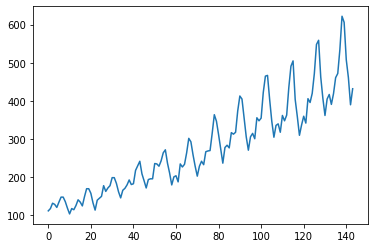

In [4]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [5]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [7]:
len(train)

96

In [8]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [9]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
# trainX

In [10]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [11]:
loss_func = nn.MSELoss()
def train_rnn(model, look_back=5, hidden=1, look_forward=1):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    epoch_losses = []
    for epoch in range(900):
        losses = []
        for i in range(len(trainY)):
            Y = Variable(torch.FloatTensor(trainY[i:i+1]))
            X = Variable(torch.FloatTensor(trainX[i:i+1]))
            #print(X)
            y_pred, _ = model(X)
            loss = loss_func(y_pred, Y)
            losses.append(np.array(loss.data))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_losses.append(np.mean(losses))
        if epoch % 10 == 0:
            sys.stdout.write('\rEpoch {0}... (Train) MSE: {1:.10f}'.format(epoch, epoch_losses[-1]))
    predicts = []
    for i in range(len(testY)):
        X = Variable(torch.FloatTensor(testX[i:i+1]))
        Y = Variable(torch.FloatTensor(testY[i:i+1]))
        y_pred, _ = model(X)
        predicts.append(np.array(y_pred.data).mean())

    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    plt.plot(epoch_losses[11:])
    plt.title("Loss with size of hidden layers {0}".format(hidden))
    
    ax2 = fig.add_subplot(122)
    plt.plot(np.array(predicts).reshape(-1), color = 'r')
    plt.plot(testY)
    plt.title("Prediction and test")
    plt.show()

### Различные значения look_back

look_back = 1
Epoch 0... (Train) MSE: 0.0087932944

/home/oleg/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 890... (Train) MSE: 0.0019789848

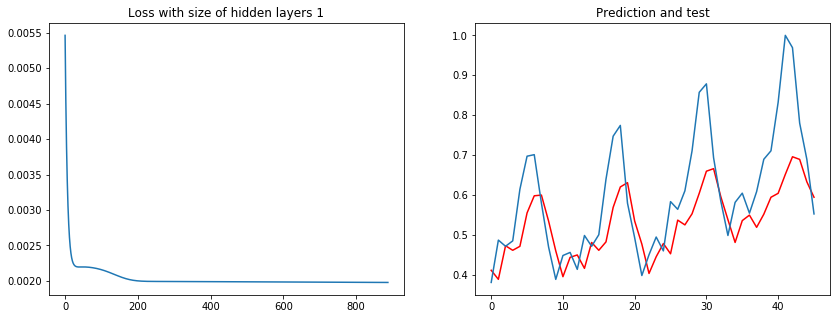

look_back = 3
Epoch 890... (Train) MSE: 0.0016998467

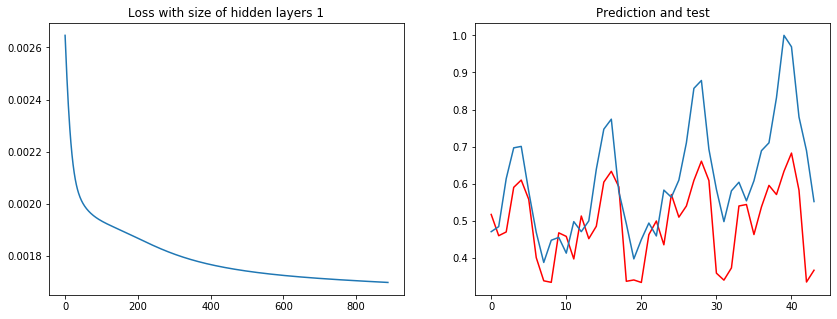

look_back = 5
Epoch 890... (Train) MSE: 0.0013371493

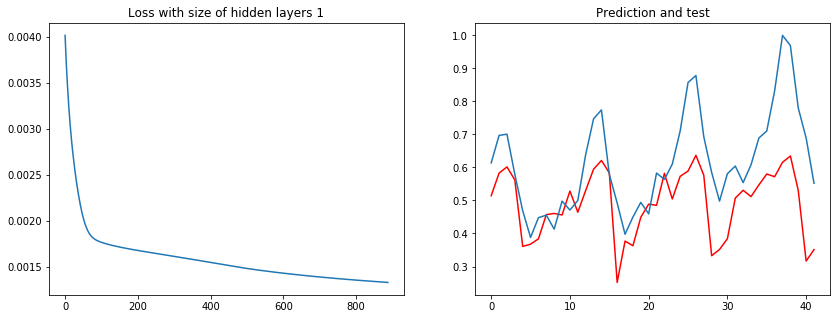

look_back = 7
Epoch 890... (Train) MSE: 0.0013098713

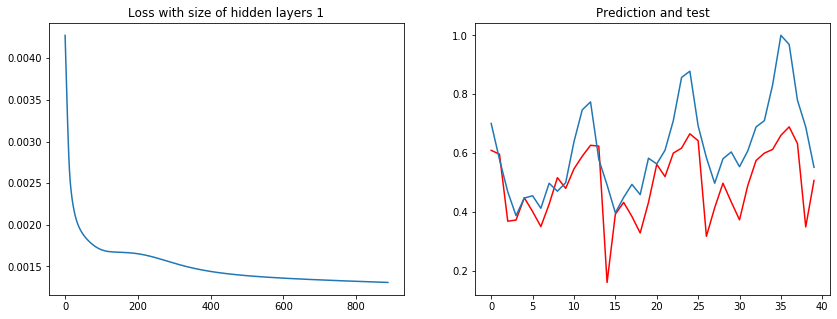

look_back = 10
Epoch 890... (Train) MSE: 0.0007406509

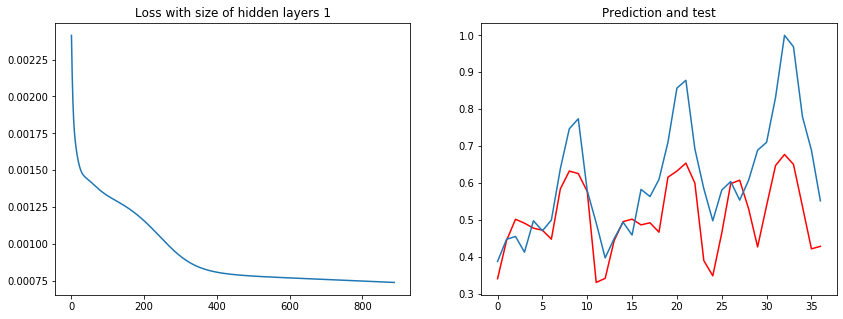

In [12]:
look_back_s = [1, 3, 5, 7, 10]
for look_back in look_back_s:
    torch_model = nn.LSTM(input_size=look_back, hidden_size=1, num_layers=1)
    print('look_back = {}'.format(look_back))
    train_rnn(torch_model, look_back)

### GRU

look_back = 1
Epoch 890... (Train) MSE: 0.0019837602

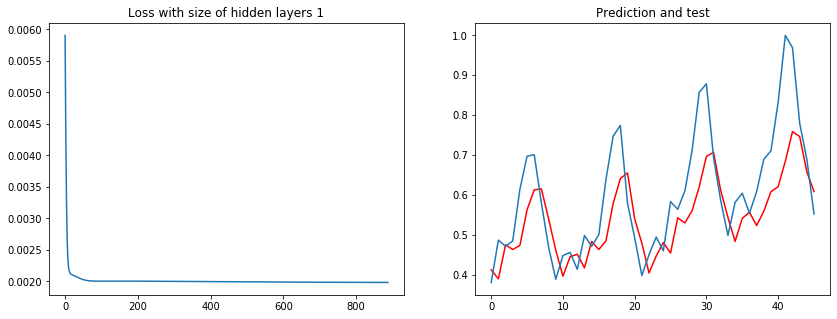

look_back = 3
Epoch 890... (Train) MSE: 0.0017033293

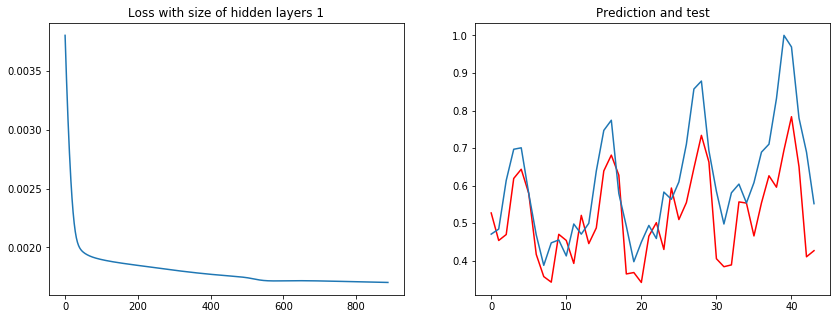

look_back = 5
Epoch 890... (Train) MSE: 0.0015882384

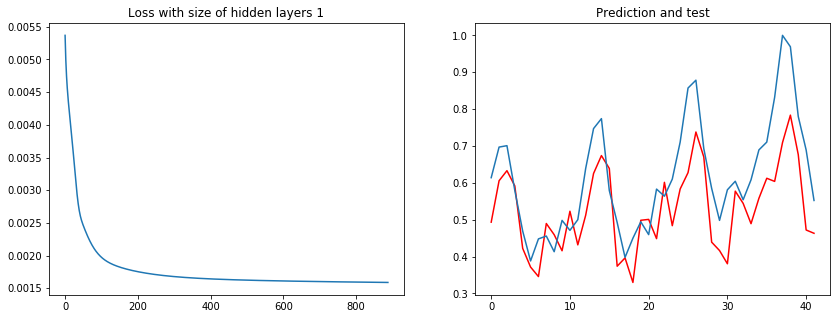

look_back = 7
Epoch 890... (Train) MSE: 0.0017097865

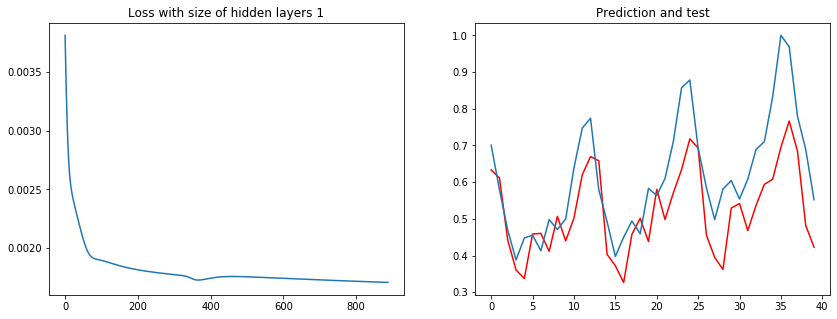

look_back = 10
Epoch 890... (Train) MSE: 0.0010882304

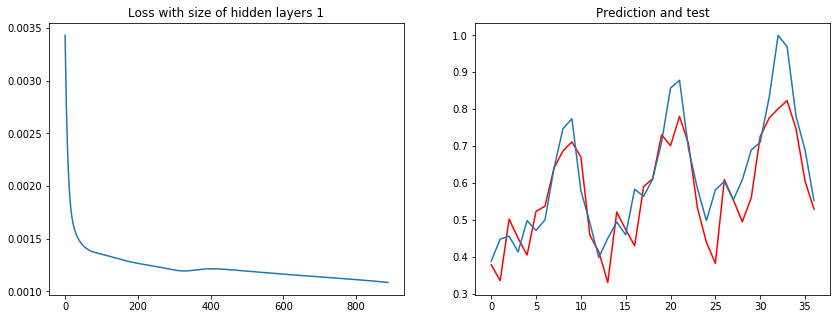

In [13]:
look_back_s = [1, 3, 5, 7, 10]
for look_back in look_back_s:
    torch_model = nn.GRU(input_size=look_back, hidden_size=1, num_layers=1)
    print('look_back = {}'.format(look_back))
    train_rnn(torch_model, look_back)

### Самописный LSTM

look_back = 1
Epoch 890... (Train) MSE: 0.0019875653

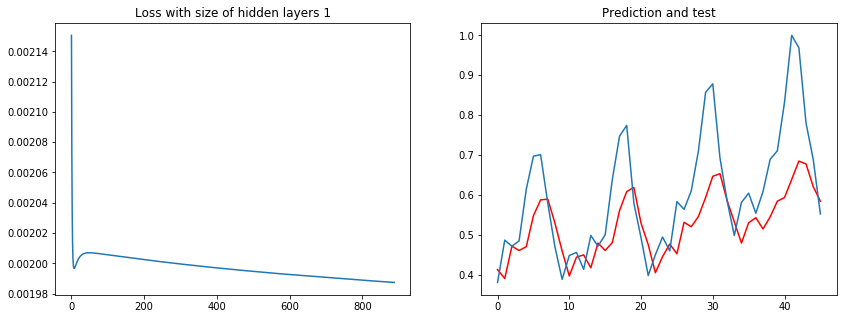

look_back = 3
Epoch 890... (Train) MSE: 0.0017012857

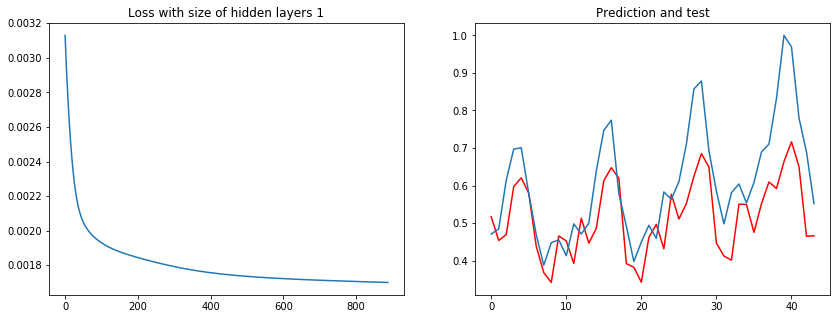

look_back = 5
Epoch 890... (Train) MSE: 0.0016023897

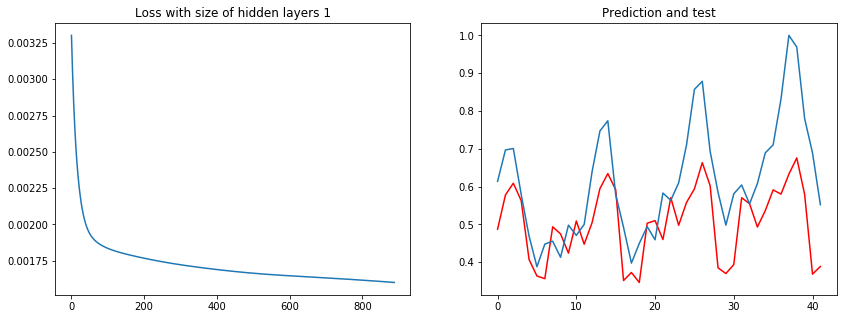

look_back = 7
Epoch 890... (Train) MSE: 0.0016170144

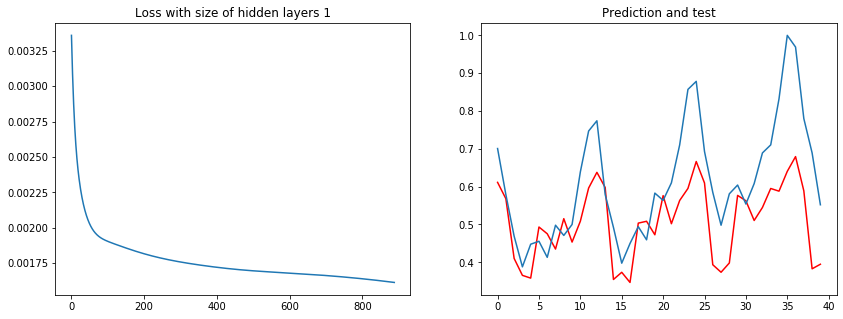

look_back = 10
Epoch 890... (Train) MSE: 0.0007955309

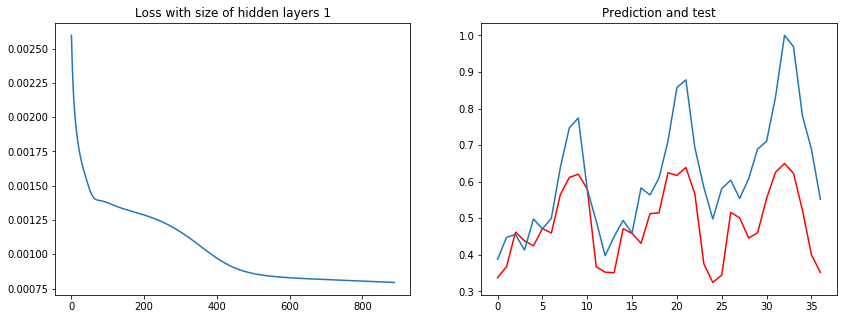

In [25]:
look_back_s = [1, 3, 5, 7, 10]
for look_back in look_back_s:
    torch_model = LSTM(input_size=look_back, hidden_size=1)
    print('look_back = {}'.format(look_back))
    train_rnn(torch_model, look_back)

## Различные значения выходной последовательности

### LSTM

Epoch 890... (Train) MSE: 0.0019968222

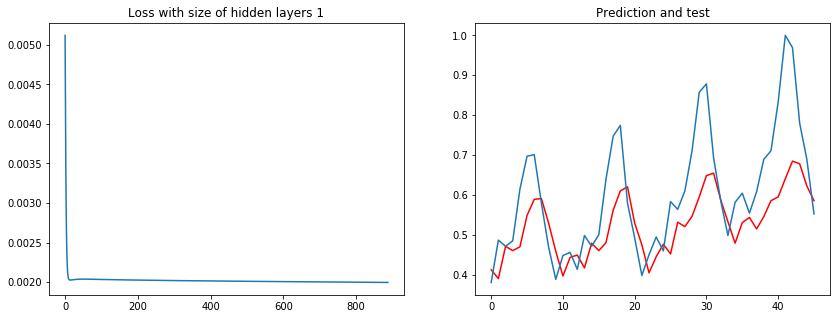

/home/oleg/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 890... (Train) MSE: 0.0019981009

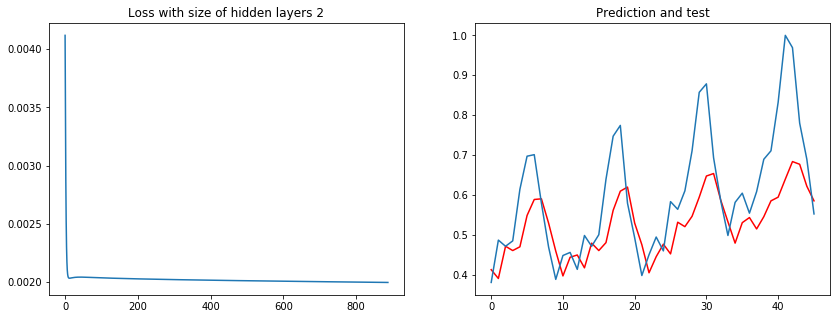

/home/oleg/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 890... (Train) MSE: 0.0019957614

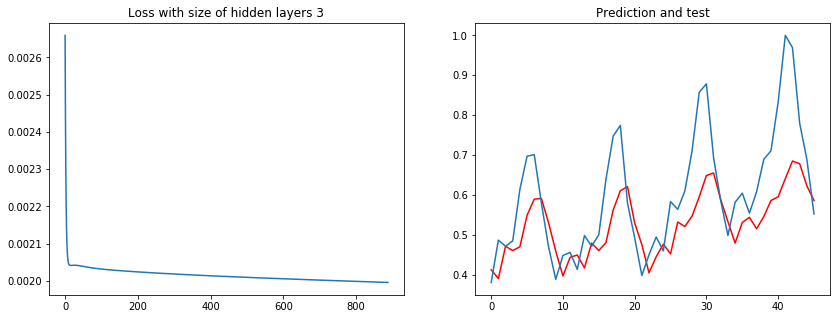

/home/oleg/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 890... (Train) MSE: 0.0019979235

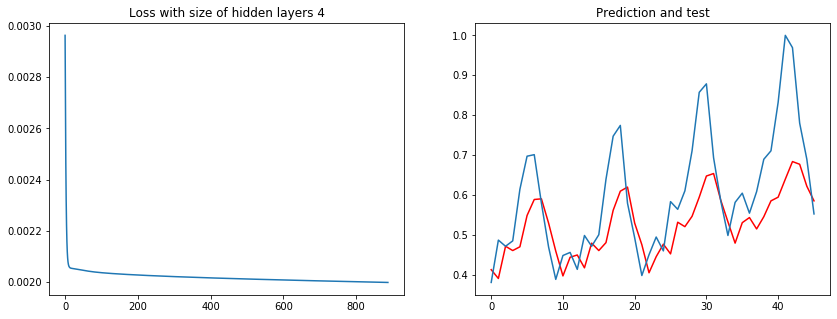

/home/oleg/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 890... (Train) MSE: 0.0019988869

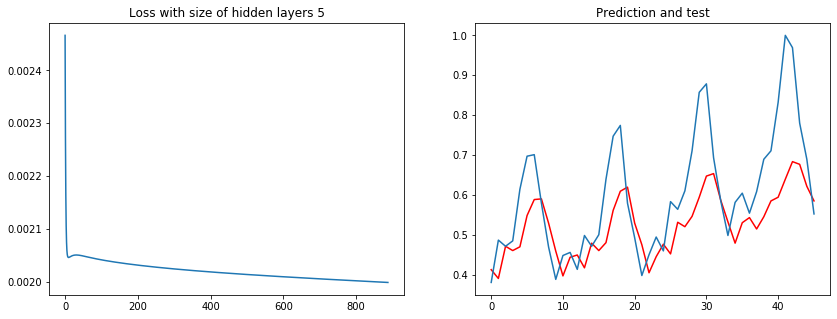

In [30]:
for i in range(1, 6):
    torch_lstm = nn.LSTM(input_size=1, hidden_size=i, num_layers=1)
    train_rnn(torch_lstm, look_back=1, hidden=i)

### GRU

Epoch 890... (Train) MSE: 0.0019920208

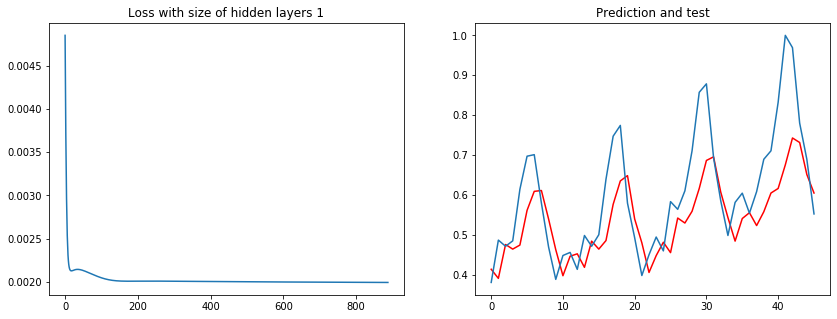

Epoch 890... (Train) MSE: 0.0019922941

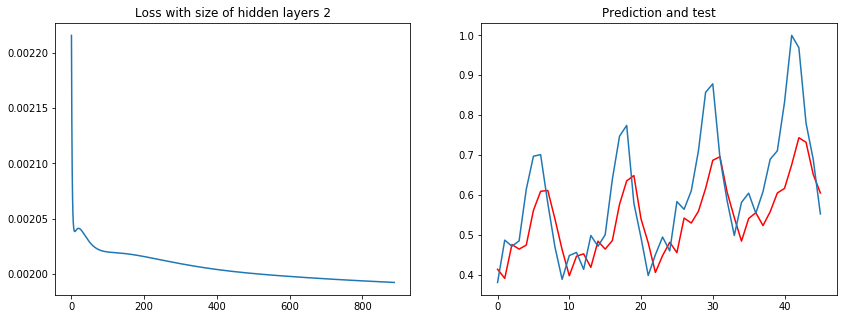

Epoch 890... (Train) MSE: 0.0019915316

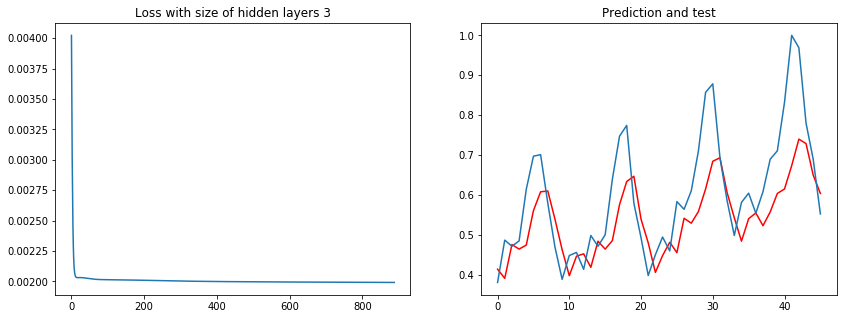

Epoch 890... (Train) MSE: 0.0019975170

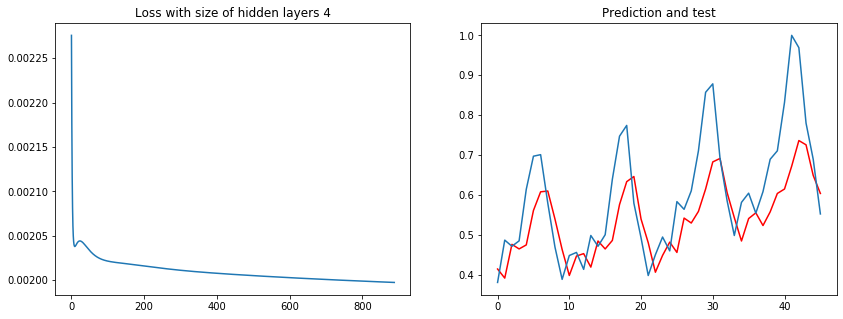

In [31]:
for i in range(1, 5):
    torch_lstm = nn.GRU(input_size=1, hidden_size=i, num_layers=1)
    train_rnn(torch_lstm, look_back=1, hidden=i)

### Самописный LSTM

Epoch 890... (Train) MSE: 0.0020587035

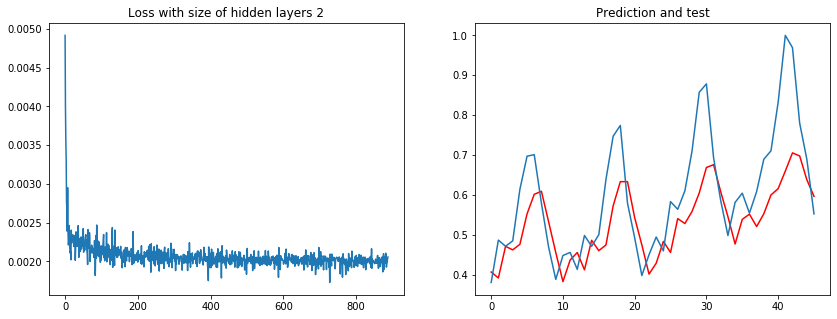

Epoch 890... (Train) MSE: 0.0020656844

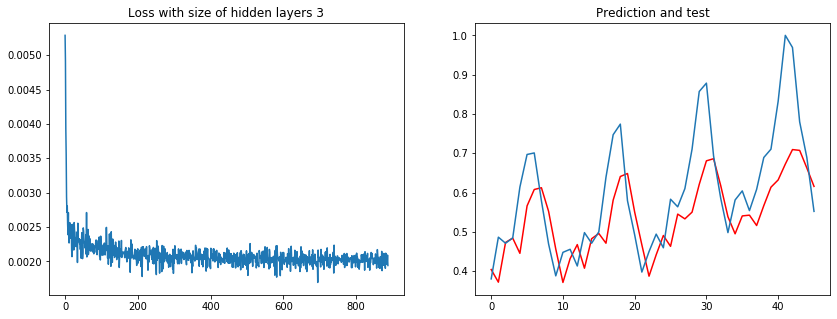

Epoch 890... (Train) MSE: 0.0019487297

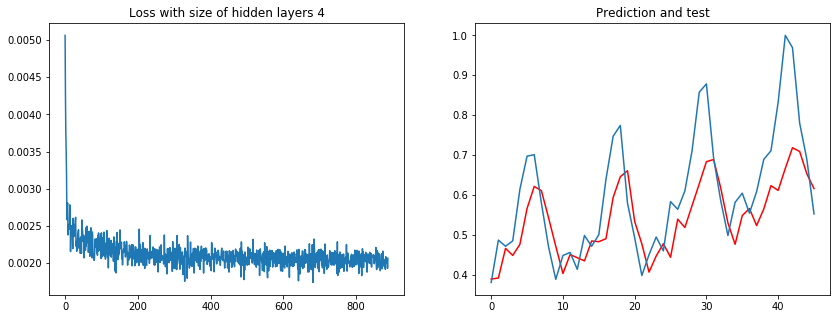

In [41]:
for i in range(2, 5):
    torch_lstm = LSTM(input_size=1, hidden_size=i)
    train_rnn(torch_lstm, look_back=1, hidden=i)

Epoch 890... (Train) MSE: 0.0011067752

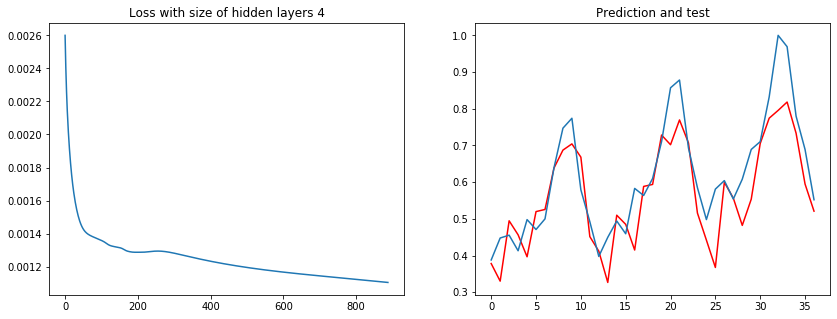

In [48]:
torch_gru = nn.GRU(input_size=10, hidden_size=4, num_layers=1)
train_rnn(torch_gru, look_back=10, hidden=4)

Epoch 890... (Train) MSE: 0.0007819630

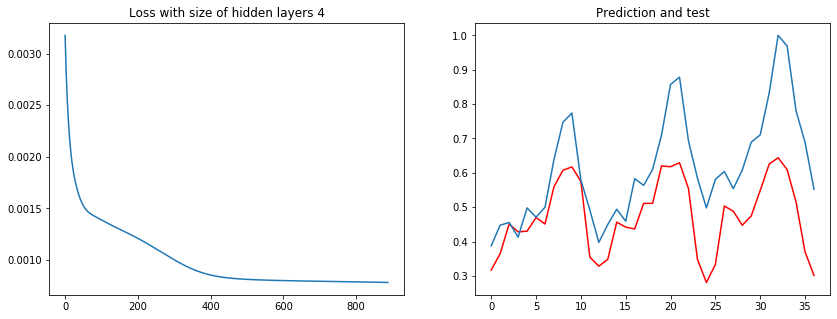

In [49]:
torch_lstm = nn.LSTM(input_size=10, hidden_size=4, num_layers=1)
train_rnn(torch_lstm, look_back=10, hidden=4)

# Выводы

Самописный lstm работает похожим образом, как и библиотечная реализация. 

Лучшие результаты достигаются на больших значениях кол-ва входных переменных, т.е. лучший результат на моем тесте был достигнут на значение 10.

Модель GRU дает более точные и стабильные результаты, тогда как lstm быстрее сходится.

Размер выходной последовательности практически не влияет на сходимость. Лушчие результаты получилось добитаться на размерности 1.


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: